In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import scipy.optimize

## Segédfüggvények

In [2]:
def cont_frac(p, q, a=[]):
    b = list(np.copy(a))
    b.append(p//q)
    if p%q == 0:
        return b
    return cont_frac(q, p-(p//q)*q, b)

def convergents(a):
    if len(a) == 1:
        return a[0], 1
    p = [a[0], 1+a[0]*a[1]]
    q = [1, a[1]]
    for i in range(2, len(a)):
        p.append(a[i]*p[i-1]+p[i-2])
        q.append(a[i]*q[i-1]+q[i-2])
    return p, q

In [3]:
def gcd(m, n): # euclid's algorithm
    a = max(m,n)
    b = min(m,n)
    if a%b == 0:
        return a, b
    c = a % b
    return gcd(b, c) # c a legnagyobb közös osztó

# determines if n is probably-prime or composite using miller rabin test. Tests k times
def is_prime(n, k=20): # miller-rabin test
    if n == 2:
        return True
    for _ in range(k):
        witness = 1
        a = random.randint(2, n-1)
        if gcd(a, n)[1] != 1:
            return False
        d = n-1
        r = 0
        while d % 2 == 0:
            d = d//2
            r += 1
        s = int_pow_mod(a, d, n)
        if s == 1:
            witness = 0
        for i in range(r):
            if s == n-1:
                witness = 0
            s = s**2 % n
        if witness == 1:
            return False
    return True

In [4]:
def int_nth_root(A, n): # calculate floor of nth root of A
    if A<0:
        if n%2 == 0:
            raise ValueError
        return -int_nth_root(-A,n)
    if A==0:
        return 0
    n1 = n-1
    if A.bit_length() < 1024: # float(n) safe from overflow
        xk = int( round( pow(A,1.0/n) ) )
        xk = ( n1*xk + A//pow(xk,n1) )//n # Ensure xk >= floor(nthroot(A)).
    else:
        xk = 1 << -(-A.bit_length()//n) # 1 << sum(divmod(A.bit_length(),n))
                                        # power of 2 closer but greater than the nth root of A
    while True:
        d = A // pow(xk,n1)
        if xk <= d:
            return xk
        xk = (n1*xk + d)//n

In [5]:
def two_pow(A, k): # computes A**(2**k), A: L bit int
    result = np.copy(A)
    for i in range(k): # k multiplying operations
        result = result**2 
    return result  # if k < L: max O(L^3) operations

def int_pow(A, n): # computes A**n in polynomal time, A: L bit int
    n_bin = list(bin(n))
    index = n_bin.index('b')
    n_bin = n_bin[index+1:]
    l = len(n_bin) # l < log(L)
    result = 1
    for i in range(l):
        bit = int(n_bin[l-i-1])
        if bit == 1:
            result = result*two_pow(A, i)
    return result # if n < A: max O(L^4) operations

In [6]:
def two_pow_mod(A, k, N): #computes A**(2**k) mod N, A: L bit int
    result = np.copy(A)
    for i in range(k): # k multiplying operations
        result = result**2 % N
    return result  # if  k < L: max O(L^3)

def int_pow_mod(A, n, N): #computes A**n mod N in polynomal time, A: L bit integer
    n_bin = list(bin(n))
    index = n_bin.index('b')
    n_bin = n_bin[index+1:]
    l = len(n_bin) # l < log(L)
    result = 1
    for i in range(l):
        bit = int(n_bin[l-i-1])
        if bit == 1:
            result = result*two_pow_mod(A, i, N) % N
    return result # if n < A:max O(L^4) operations

In [7]:
def find_int_pow(N):
    n = N.bit_length()
    for i in range(2, n):
        a = int_nth_root(N, i)
        if int_pow(a, i) == N:
            return a, i
    return N, 1

def order(a, N): 
    if gcd(a, N)[1] != 1:
        raise ValueError("a and N have to be coprime")
    s = 1
    i = 0
    while i == 0 or s != 1:
        s = (a*s) % N
        i += 1
    return i

## Számolás, ábrakészítés

In [8]:
p = []
N = 21
n = N.bit_length()
a = 5
r = order(a, N)
success = []
fail = []
for cbits in range(3, 12):
    success.append([])
    fail.append([])
    i = cbits-3
    M = 2**(cbits)
    n = N.bit_length()
    b = {}
    for k in range(M):
        d = k % r
        if d in b.keys():
            b[d] = b[d] + [k]
        else:
            b[d] = [k]
    p.append({})
    for c in range(M):
        m, q = convergents(cont_frac(c, M))
        q = np.array(q, dtype = int)
        r1 = max(q[q <= N])
        prob = 0
        for d in range(r): #!!!!
            compl = 0
            for k in b[d]:
                compl += np.exp(2*np.pi*1j*k*c/M)
            prob += abs(compl)**2
        prob = prob/M**2
        p[i][c] = prob
        if r1 == r:
            success[i].append(c)
        else:
            fail[i].append(c)

10
0.3265991964231585 0.6734008035768388 0.9999999999999973


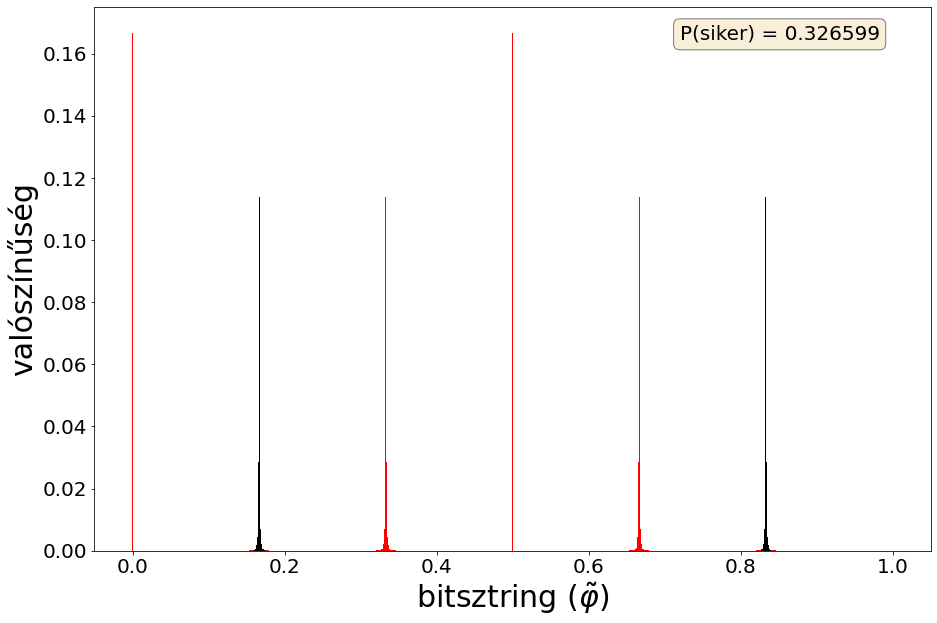

In [19]:
for i in range(7,8):
    cbits = i+3
    print(cbits)
    s = sum([p[i][j] for j in success[i]])
    f = sum([p[i][j] for j in fail[i]])
    print(s, f, (s+f))
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.bar(np.array(success[i])/2**(cbits), [p[i][j] for j in success[i]], color='black', width=0.002)
    ax.bar(np.array(fail[i])/2**(cbits), [p[i][j] for j in fail[i]], width=0.002, color='red')
    #ax.set_title('%i darab kontroll qubit' % cbits, fontsize=20)
    ax.set_xlabel(r'bitsztring ($\tilde{\varphi}$)', fontsize=30)
    ax.set_ylabel('valószínűség',fontsize=30)
    matplotlib.rcParams.update({'font.size': 20})
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.7, 0.95, 'P(siker) = %f' %s, fontsize=20,transform=ax.transAxes, 
    verticalalignment='center', bbox=props)
    plt.savefig('bitsztring_21_5_%i' %cbits)

In [58]:
sum([p[5][i] for i in range(2**8)])

0.8320312499999998

## readout error hatásának szemléltetése

In [10]:
p_flip = 0.1
l = 10
p1 = p[l-3]
p2 = {}
for c in range(2**l):
    c_bits = list(bin(c))
    index = c_bits.index('b')
    c_bits = c_bits[index+1:]
    while len(c_bits) < l:
        c_bits.insert(0, 0)
    c_bits = np.array(c_bits, dtype=int)
    prob = 0
    for d in range(2**l):
        d_bits = list(bin(d))
        index = d_bits.index('b')
        d_bits = d_bits[index+1:]
        while len(d_bits) < l:
            d_bits.insert(0, 0)
        d_bits = np.array(d_bits, dtype=int)
        bitflips = 0
        for i in range(l):
            if d_bits[i] != c_bits[i]:
                bitflips += 1
        prob += p1[d]*p_flip**bitflips*(1-p_flip)**(l-bitflips)
    p2[c] = prob

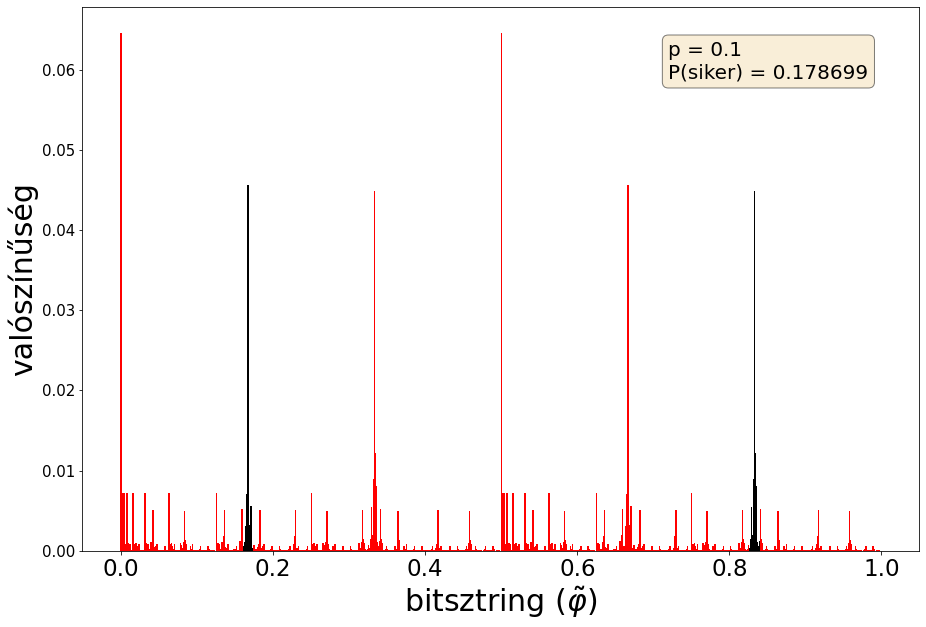

In [12]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.bar(np.array(success[l-3])/2**l, [p2[j] for j in success[l-3]], width=0.002, color='black')
ax.bar(np.array(fail[l-3])/2**l, [p2[j] for j in fail[l-3]], width=0.002, color='red')
#ax.set_title('%i darab kontrol qubit' % l, fontsize=20)
ax.set_xlabel(r'bitsztring ($\tilde{\varphi}$)', fontsize=30)
ax.set_ylabel('valószínűség',fontsize=30)
plt.xticks(fontsize=23)
plt.xticks(fontsize=23)
matplotlib.rcParams.update({'font.size': 15})
s = sum([p2[j] for j in success[l-3]])
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.7, 0.9, 'p = 0.1\nP(siker) = %f' %s, fontsize=20,transform=ax.transAxes, 
verticalalignment='center', bbox=props)
plt.savefig('bits_error_%i' %l)

In [9]:
p = []
N = 21
n = N.bit_length()
a = 5
r = order(a, N)
cbits = 12
M = 2**(cbits)
n = N.bit_length()
b = {}
for k in range(M):
    d = k % r
    if d in b.keys():
        b[d] = b[d] + [k]
    else:
        b[d] = [k]
p = []
for c in range(M):
    prob = 0
    for d in range(1, r):
        compl = 0
        for k in b[d]:
            compl += np.exp(2*np.pi*1j*k*c/M)
        prob += abs(compl)**2
    prob = prob/M**2
    p.append(prob)
p = np.array(p)

In [26]:
p_max = 1-1/2**(1.0/(2*n+2))
p_r = 6.2*10**-2
n_max = (-1.0/np.log2(1-p_r)-2)/2
print(n_max)
p = p_r
n = 10
for i in range(2, 2*n+2, 2):
    print((i-2)//2, (1-p)**i)

4.414761402064501
0 0.8798439999999998
1 0.7741254643359998
2 0.6811096450432433
3 0.5992702345334273
4 0.5272643202328288
5 0.46391034857093294
6 0.4081687367280439
7 0.359124813997749
8 0.3159738128470354
9 0.278007663390587


## Nagyítás

Text(0, 0.5, 'valószínűség')

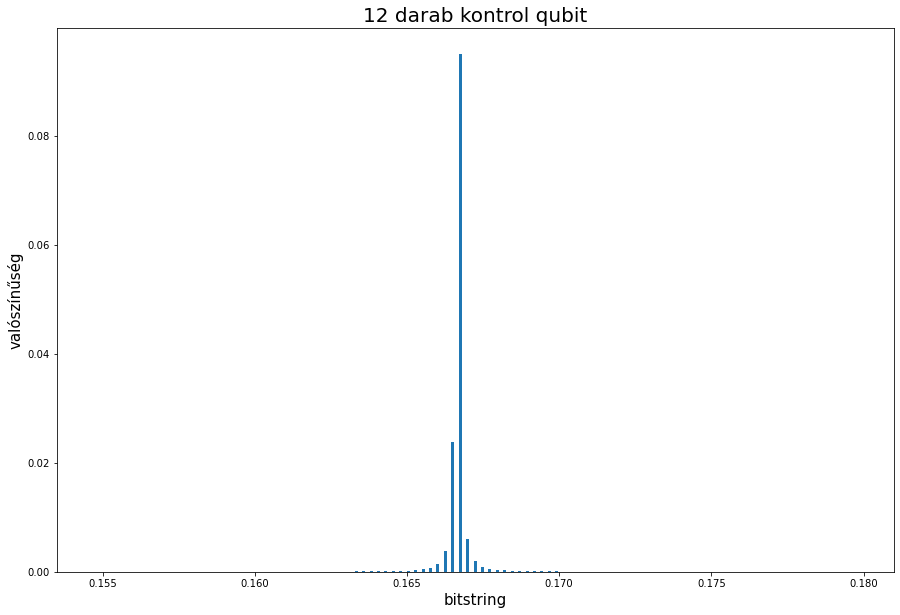

In [38]:
bins = [int(len(p)*0.155), int(len(p)*0.18)]
fig, ax = plt.subplots(figsize=(15, 10))
p_1 = p[bins[0]: bins[1]]
bits_1 = np.array(range(M))[bins[0]: bins[1]]/M
ax.bar(bits_1, p_1, width=0.0001)
ax.set_title('%i darab kontrol qubit' % cbits, fontsize=20)
ax.set_xlabel('bitstring', fontsize=15)
ax.set_ylabel('valószínűség',fontsize=15)

## Csak 8 qubit mérése

[0.13829529126537285, 0.13827155299003854, 0.1394487807445882, 0.13829529126537313, 0.13827155299003918]
[0.13859751915932242, 0.13859248580385522, 0.13882562003682267, 0.1385975191593223, 0.1385924858038548]
[0.13874167390982367, 0.13873367984573068, 0.13902855249444548, 0.13874167390982184, 0.13873367984573112]
[0.13881687047485808, 0.13881402068653514, 0.13887301508860694, 0.1388168704748585, 0.13881402068653448]
[0.13885215719006783, 0.1388500296474211, 0.138923789725011, 0.13885215719006694, 0.13885002964742038]
[0.1388709355745718, 0.13887012362765977, 0.13888491736026878, 0.13887093557457125, 0.1388701236276604]
[0.13887971043608965, 0.13887917048144424, 0.13889761322309144, 0.1388797104360869, 0.1388791704814443]


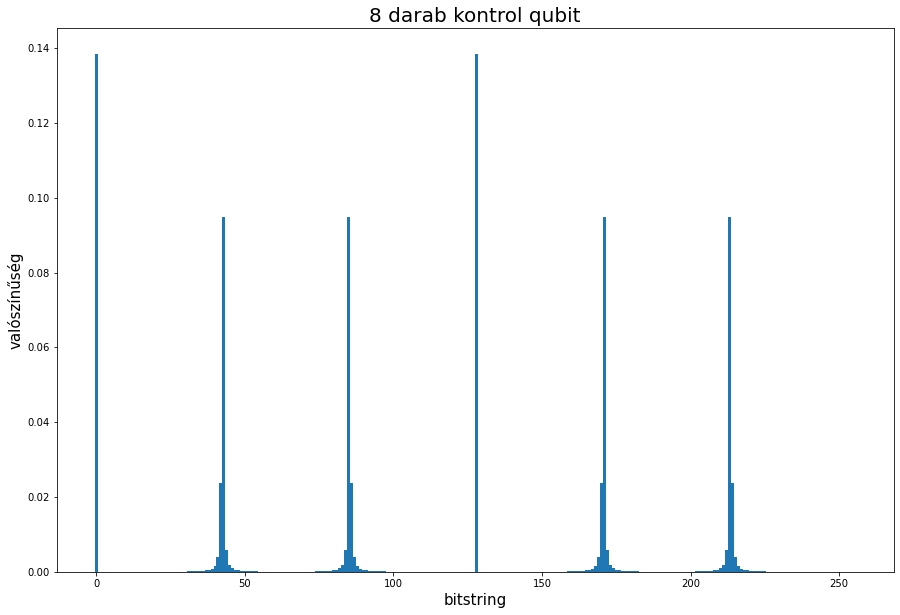

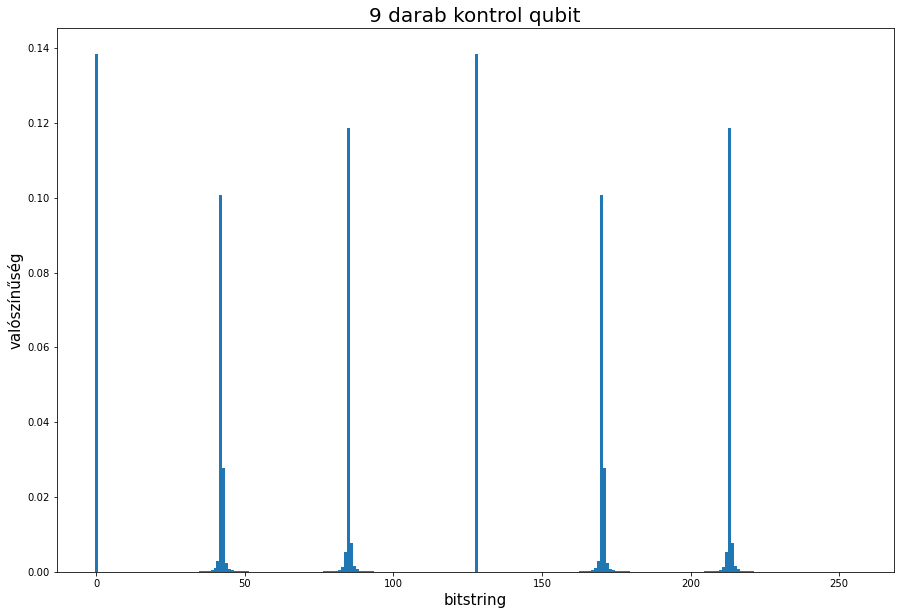

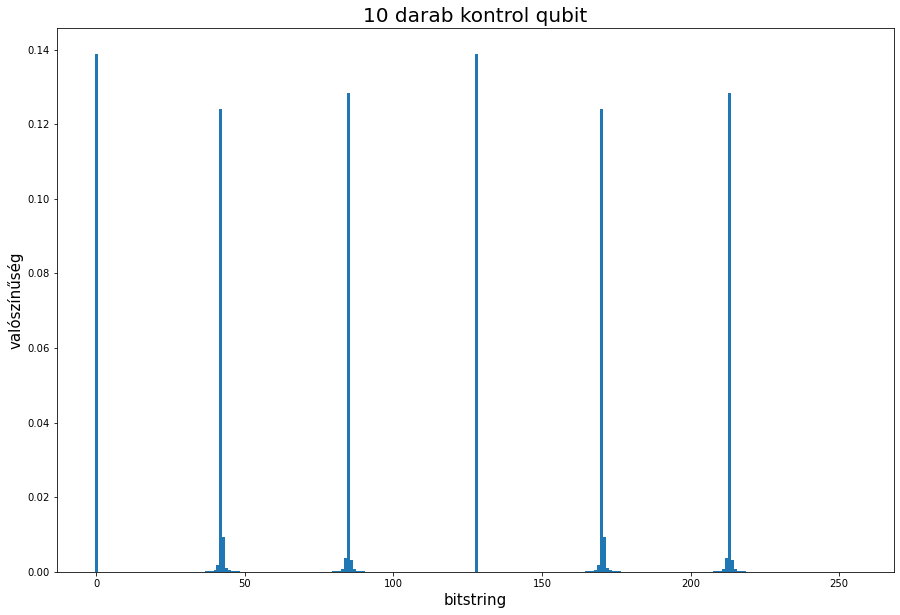

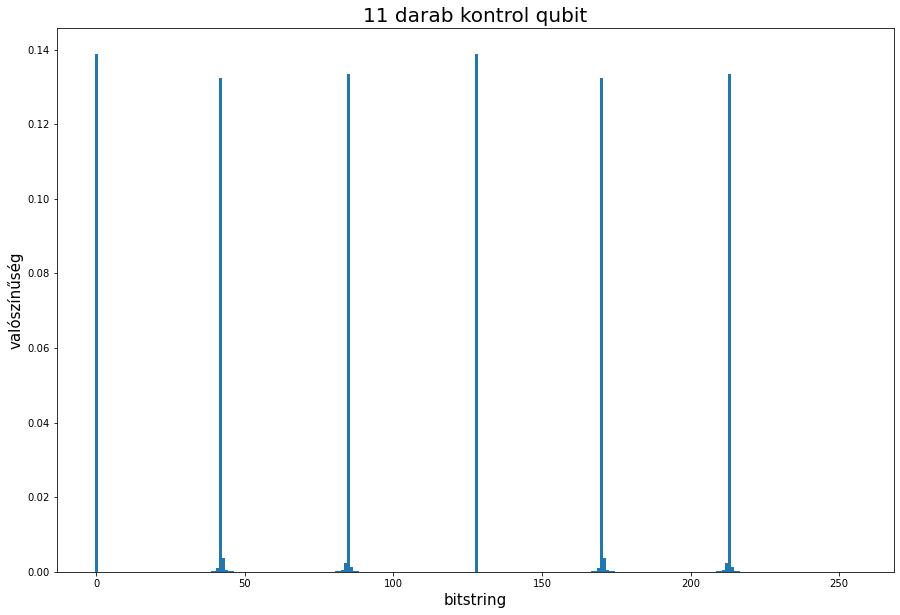

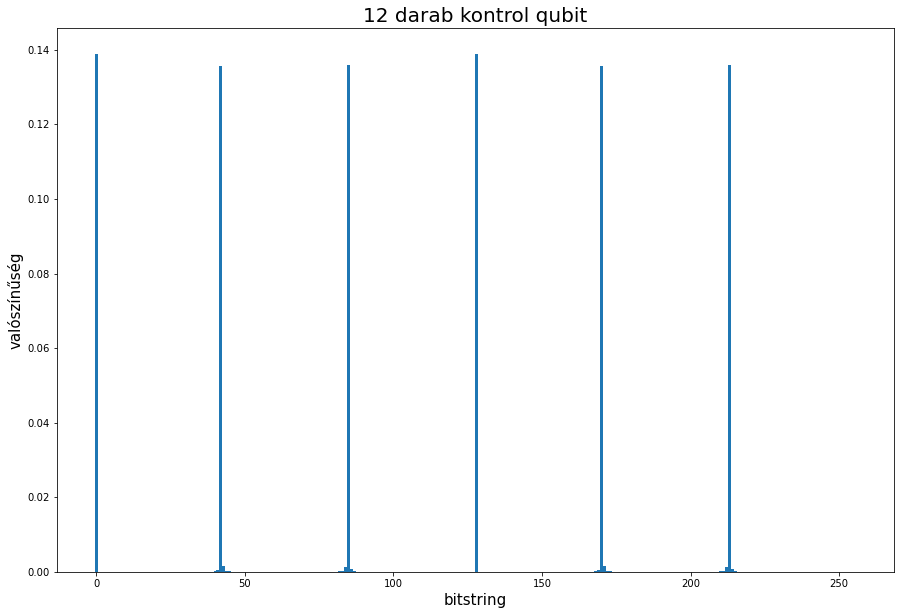

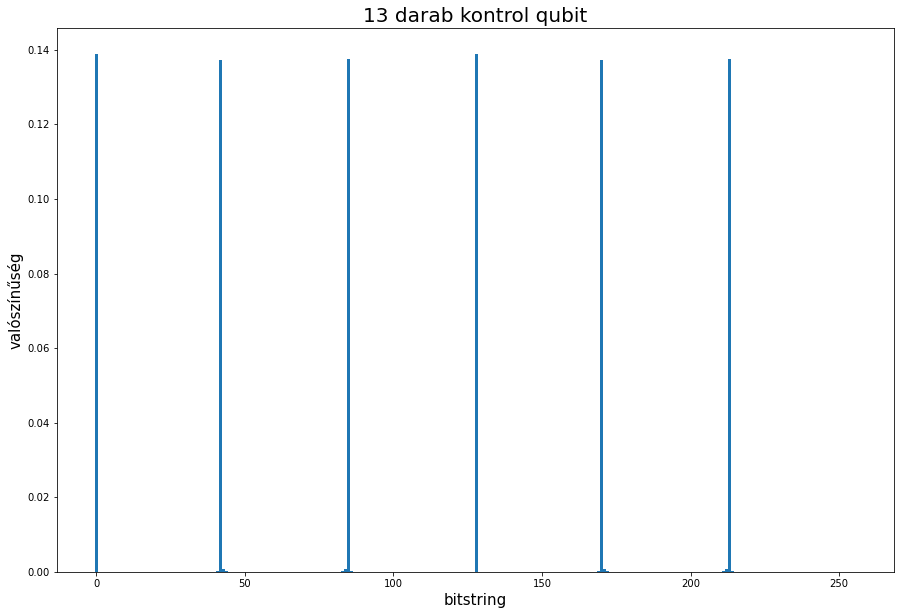

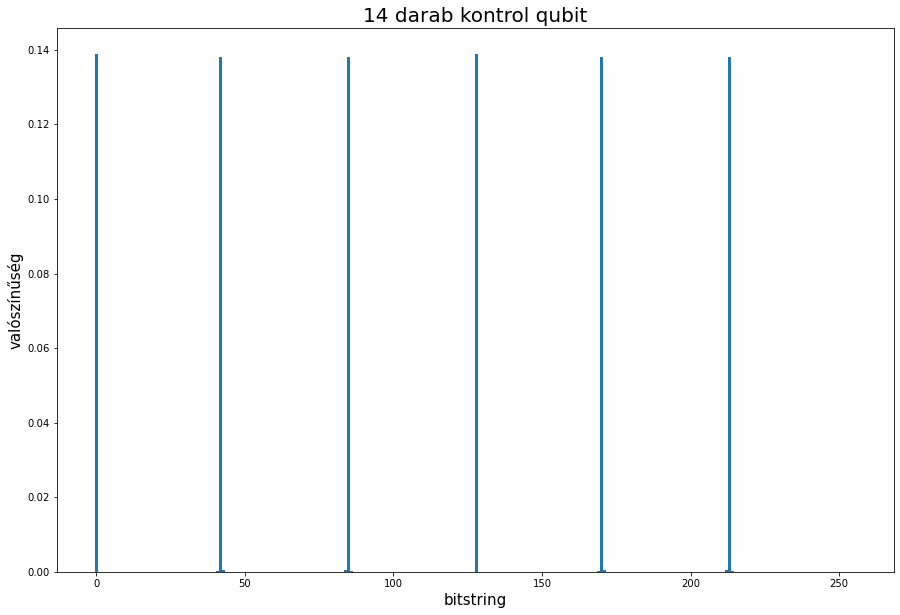

In [46]:
p = []
N = 21
n = N.bit_length()
a = 5
r = order(a, N)
for cbits in range(8, 15):
    M = 2**(cbits)
    n = N.bit_length()
    b = {}
    for k in range(M):
        d = k % r
        if d in b.keys():
            b[d] = b[d] + [k]
        else:
            b[d] = [k]
    p = []
    for c in range(2**8):
        prob = 0
        for e in range(2**(cbits-8)):
            for d in range(1, r):
                compl = 0
                for k in b[d]:
                    compl += np.exp(2*np.pi*1j*k*(c*2**(cbits-8)+e)/M)
                prob += abs(compl)**2
        prob = prob/M**2
        p.append(prob)
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.bar(np.array(range(2**8)), p, width=1)
    ax.set_title('%i darab kontrol qubit' % cbits, fontsize=20)
    ax.set_xlabel('bitstring', fontsize=15)
    ax.set_ylabel('valószínűség',fontsize=15)
    bins = [(len(p)*i)//12 for i in range(12)]
    prob_s = [sum(p[bins[2*i+1]: bins[2*i+3]]) for i in range(5)]
    print(prob_s)